In [2]:


import sys
import numpy as np
import pandas as pd
import rasterio
import refet
import pyproj as proj
import xarray
import requests
import multiprocessing as mp
import matplotlib.pyplot as plt
import configparser
import pathlib

In [3]:
#sys.path.append("//")
sys.path.append("../../../Micromet")
import micromet
from micromet.volk import ffp_climatology as ffp
from micromet import AmerifluxDataProcessor

In [4]:

# load initial flux data
station = 'US-UTW'
config_path = f'../../station_config/{station}.ini'
config = configparser.ConfigParser()
config.read(config_path)

spath = "../../secrets/config.ini"
sconfig = configparser.ConfigParser()
sconfig.read(spath)

ed_pass = sconfig['NLDAS']['pw']
ed_user = sconfig['NLDAS']['user']

In [8]:
import datetime

#nldas_out_dir = Path('C:/Users/paulinkenbrandt/Documents/GitHub/MicroMet/Notebooks/Footprints')


for date in pd.date_range(start='2021-01-01', end='2025-02-01',freq='h'):
    hour = date.hour
    micromet.download_nldas(date,
                           hour,
                           ed_user,
                           ed_pass,)

NLDAS_data\2022_01_01_00.nc already exists, not overwriting.
NLDAS_data\2022_01_01_01.nc already exists, not overwriting.
NLDAS_data\2022_01_01_02.nc already exists, not overwriting.
NLDAS_data\2022_01_01_03.nc already exists, not overwriting.
NLDAS_data\2022_01_01_04.nc already exists, not overwriting.
NLDAS_data\2022_01_01_05.nc already exists, not overwriting.
NLDAS_data\2022_01_01_06.nc already exists, not overwriting.
NLDAS_data\2022_01_01_07.nc already exists, not overwriting.
NLDAS_data\2022_01_01_08.nc already exists, not overwriting.
NLDAS_data\2022_01_01_09.nc already exists, not overwriting.
NLDAS_data\2022_01_01_10.nc already exists, not overwriting.
NLDAS_data\2022_01_01_11.nc already exists, not overwriting.
NLDAS_data\2022_01_01_12.nc already exists, not overwriting.
NLDAS_data\2022_01_01_13.nc already exists, not overwriting.
NLDAS_data\2022_01_01_14.nc already exists, not overwriting.
NLDAS_data\2022_01_01_15.nc already exists, not overwriting.
NLDAS_data\2022_01_01_16

In [9]:
# Define Utah's latitude and longitude boundaries
utah_lat_min, utah_lat_max = 37.0, 42.0
utah_lon_min, utah_lon_max = -114.0, -109.0

# List of uploaded NetCDF files
netcdf_files = pathlib.Path("./NLDAS_data/")

for year in [2021,2022,2023,2024]:
    print(year)
    # Extract Utah-specific data from each file and store datasets
    utah_datasets = []
    for file in netcdf_files.glob(f'{year}*.nc'):
        print(file)
        ds_temp = xarray.open_dataset(file)
        ds_utah_temp = ds_temp.sel(lat=slice(utah_lat_min, utah_lat_max), lon=slice(utah_lon_min, utah_lon_max))
        utah_datasets.append(ds_utah_temp)

    # Merge all extracted datasets along the time dimension
    ds_merged = xarray.concat(utah_datasets, dim="time")

    # Save as NetCDF using a compatible format (default for xarray in this environment)
    netcdf_output_path = f"{year}_utah_merged.nc"
    ds_merged.to_netcdf(netcdf_output_path)

    # Convert to Pandas DataFrame for Parquet format
    df_parquet = ds_merged.to_dataframe().reset_index()

    # Save as Parquet
    parquet_output_path = f"{year}_utah_merged.parquet"
    df_parquet.to_parquet(parquet_output_path, engine="pyarrow")

    # Provide download links
    print(netcdf_output_path, parquet_output_path)


2022
NLDAS_data\2022_01_01_00.nc
NLDAS_data\2022_01_01_01.nc
NLDAS_data\2022_01_01_02.nc
NLDAS_data\2022_01_01_03.nc
NLDAS_data\2022_01_01_04.nc
NLDAS_data\2022_01_01_05.nc
NLDAS_data\2022_01_01_06.nc
NLDAS_data\2022_01_01_07.nc
NLDAS_data\2022_01_01_08.nc
NLDAS_data\2022_01_01_09.nc
NLDAS_data\2022_01_01_10.nc
NLDAS_data\2022_01_01_11.nc
NLDAS_data\2022_01_01_12.nc
NLDAS_data\2022_01_01_13.nc
NLDAS_data\2022_01_01_14.nc
NLDAS_data\2022_01_01_15.nc
NLDAS_data\2022_01_01_16.nc
NLDAS_data\2022_01_01_17.nc
NLDAS_data\2022_01_01_18.nc
NLDAS_data\2022_01_01_19.nc
NLDAS_data\2022_01_01_20.nc
NLDAS_data\2022_01_01_21.nc
NLDAS_data\2022_01_01_22.nc
NLDAS_data\2022_01_01_23.nc
NLDAS_data\2022_01_02_00.nc
NLDAS_data\2022_01_02_01.nc
NLDAS_data\2022_01_02_02.nc
NLDAS_data\2022_01_02_03.nc
NLDAS_data\2022_01_02_04.nc
NLDAS_data\2022_01_02_05.nc
NLDAS_data\2022_01_02_06.nc
NLDAS_data\2022_01_02_07.nc
NLDAS_data\2022_01_02_08.nc
NLDAS_data\2022_01_02_09.nc
NLDAS_data\2022_01_02_10.nc
NLDAS_data\2022

In [10]:
import numpy as np
import pandas as pd
import refet

for year in [2021,2022,2023,2024]:
    print(year)

    ds = xarray.open_dataset(f"{year}_utah_merged.nc",)

    # Convert temperature to Celsius
    temp = ds["Tair"].values - 273.15

    # Compute actual vapor pressure (ea)
    pair = ds["PSurf"].values / 1000  # Convert pressure from Pa to kPa
    sph = ds["Qair"].values  # Specific humidity (kg/kg)
    ea = refet.calcs._actual_vapor_pressure(q=sph, pair=pair)  # Vapor pressure (kPa)

    # Compute wind speed from u and v components
    wind_u = ds["Wind_E"].values
    wind_v = ds["Wind_N"].values
    uz = np.sqrt(wind_u**2 + wind_v**2)  # Wind speed (m/s)

    # Extract shortwave radiation
    rs = ds["SWdown"].values  # Solar radiation (W/m²)

    # Extract time variables
    time_vals = ds["time"].values  # Convert to numpy datetime64
    dt_index = pd.to_datetime(time_vals)  # Convert to Pandas datetime index
    DOY = dt_index.dayofyear.values  # Day of year
    HH = dt_index.hour.values  # Hour of day
    # Expand DOY and HH to match (time, lat, lon) shape
    doy_expanded = np.broadcast_to(DOY[:, np.newaxis, np.newaxis], temp.shape)
    hh_expanded = np.broadcast_to(HH[:, np.newaxis, np.newaxis], temp.shape)
    # Define input units
    unit_dict = {"rs": "w/m2"}

    # Define elevation, latitude, longitude (assuming a single representative point)
    # If applying to a grid, these should be arrays matching lat/lon grid dimensions
    #elevation = 1500  # Example elevation in meters, replace with actual value
    #latitude = ds["lat"].values.mean()  # Take the mean latitude of the dataset
    #longitude = ds["lon"].values.mean()  # Take the mean longitude of the dataset

    # Define measurement height (assumed)
    zw = 2.0  # Wind measurement height in meters
    zm = zw  # Assuming same height for temperature/humidity

    # Define elevation range (664m to 4125m, step 100m)
    elevation_range = np.arange(1100, 2000, 25)

    # Create an empty array to store ETo values
    eto_results = np.zeros((len(elevation_range),) + temp.shape)  # Shape (elevations, time, lat, lon)
    etr_results = np.zeros((len(elevation_range),) + temp.shape)

    # Loop over elevations and compute ETo
    for i, elev in enumerate(elevation_range):
        refet_obj = refet.Hourly(
            tmean=temp, ea=ea, rs=rs, uz=uz,
            zw=2, elev=elev, lat=ds["lat"].values, lon=ds["lon"].values,
            doy=doy_expanded, time=hh_expanded, method="asce", input_units={"rs": "w/m2"}
        )
        eto_results[i] = refet_obj.eto()  # Store ETo results for each elevation
        etr_results[i] = refet_obj.etr()  # Store ETr results for each elevation


    # Convert ETo results to an xarray DataArray
    eto_da = xarray.DataArray(
        data=eto_results,
        dims=("elevation", "time", "lat", "lon"),
        coords={
            "elevation": elevation_range,
            "time": ds["time"],
            "lat": ds["lat"],
            "lon": ds["lon"]
        },
        attrs={"units": "mm/hour", "description": "Hourly reference evapotranspiration (ASCE) at different elevations"}
    )

    # Convert ETo results to an xarray DataArray
    etr_da = xarray.DataArray(
        data=etr_results,
        dims=("elevation", "time", "lat", "lon"),
        coords={
            "elevation": elevation_range,
            "time": ds["time"],
            "lat": ds["lat"],
            "lon": ds["lon"]
        },
        attrs={"units": "mm/hour", "description": "Hourly reference evapotranspiration (ASCE) at different elevations"}
    )


    # Add ETo to the dataset
    ds = ds.assign(ETo=eto_da)
    # Add ETo to the dataset
    ds = ds.assign(ETr=etr_da)


    # Save the modified dataset (Optional)
    ds.to_netcdf(f"{year}_with_eto.nc")

# Display dataset summary to confirm ETo is included
ds



2022
2023
2024


<xarray.Dataset> Size: 9GB
Dimensions:      (time: 8784, bnds: 2, lat: 40, lon: 40, elevation: 36)
Coordinates:
  * lon          (lon) float32 160B -113.9 -113.8 -113.7 ... -109.2 -109.1
  * lat          (lat) float32 160B 37.06 37.19 37.31 ... 41.69 41.81 41.94
  * time         (time) datetime64[ns] 70kB 2024-01-01 ... 2024-12-31T23:00:00
  * elevation    (elevation) int64 288B 1100 1125 1150 1175 ... 1925 1950 1975
Dimensions without coordinates: bnds
Data variables: (12/14)
    time_bnds    (time, bnds) datetime64[ns] 141kB ...
    Tair         (time, lat, lon) float32 56MB 284.3 281.7 284.6 ... 264.8 264.2
    Qair         (time, lat, lon) float32 56MB 0.002885 0.002538 ... 0.002097
    PSurf        (time, lat, lon) float32 56MB 9.004e+04 8.587e+04 ... 7.794e+04
    Wind_E       (time, lat, lon) float32 56MB -0.92 -0.8 -0.69 ... 3.94 4.01
    Wind_N       (time, lat, lon) float32 56MB 0.74 0.6 0.47 ... 0.74 0.48 0.4
    ...           ...
    CAPE         (time, lat, lon) float32 56MB ...
    PotEvap      (time, lat, lon) float32 56MB ...
    Rainf        (time, lat, lon) float32 56MB ...
    SWdown       (time, lat, lon) float32 56MB 36.63 35.89 34.81 ... 119.6 117.0
    ETo          (elevation, time, lat, lon) float64 4GB 0.01919 ... 0.01492
    ETr          (elevation, time, lat, lon) float64 4GB 0.03045 ... 0.02338
Attributes: (12/17)
    missing_value:          -9999.0
    time_definition:        hourly
    shortname:              NLDAS_FORA0125_H_2.0
    title:                  NLDAS Primary Forcing Data L4 Hourly 0.125 x 0.12...
    version:                2.0
    institution:            NASA GSFC
    ...                     ...
    websites:               https://ldas.gsfc.nasa.gov/nldas/ ; https://lis.g...
    MAP_PROJECTION:         EQUIDISTANT CYLINDRICAL
    SOUTH_WEST_CORNER_LAT:  25.0625
    SOUTH_WEST_CORNER_LON:  -124.9375
    DX:                     0.125
    DY:                     0.125

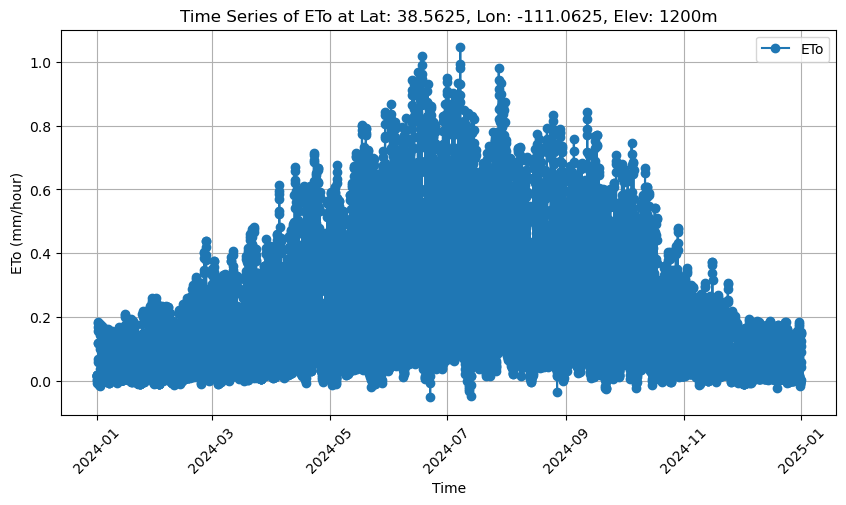

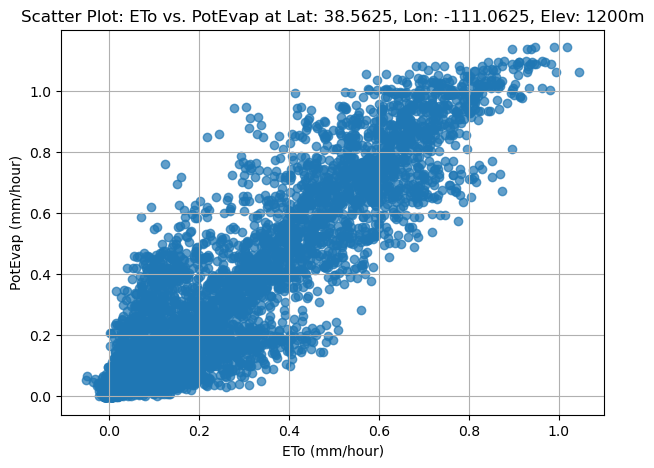

In [11]:
# Define the target latitude, longitude, and elevation (adjust as needed)
target_lat = 38.56  # Example latitude
target_lon = -111.1  # Example longitude
target_elev = 1200  # Example elevation

# Find the nearest latitude, longitude, and elevation in the dataset
nearest_lat = ds["lat"].sel(lat=target_lat, method="nearest").values
nearest_lon = ds["lon"].sel(lon=target_lon, method="nearest").values
nearest_elev = ds["elevation"].sel(elevation=target_elev, method="nearest").values

# Extract ETo time series at the nearest matching location
eto_timeseries = ds["ETo"].sel(elevation=nearest_elev, lat=nearest_lat, lon=nearest_lon)

# Extract PotEvap time series at the same location
pot_evap_timeseries = ds["PotEvap"].sel(lat=nearest_lat, lon=nearest_lon)

# Plot time series of ETo
plt.figure(figsize=(10, 5))
plt.plot(ds["time"], eto_timeseries, marker='o', linestyle='-', label="ETo")
plt.xlabel("Time")
plt.ylabel("ETo (mm/hour)")
plt.title(f"Time Series of ETo at Lat: {nearest_lat}, Lon: {nearest_lon}, Elev: {nearest_elev}m")
plt.legend()
plt.xticks(rotation=45)
plt.grid()
plt.show()

# Plot scatter plot of ETo vs PotEvap
plt.figure(figsize=(7, 5))
plt.scatter(eto_timeseries.values.flatten(), pot_evap_timeseries.values.flatten(), alpha=0.7)
plt.xlabel("ETo (mm/hour)")
plt.ylabel("PotEvap (mm/hour)")
plt.title(f"Scatter Plot: ETo vs. PotEvap at Lat: {nearest_lat}, Lon: {nearest_lon}, Elev: {nearest_elev}m")
plt.grid()
plt.show()


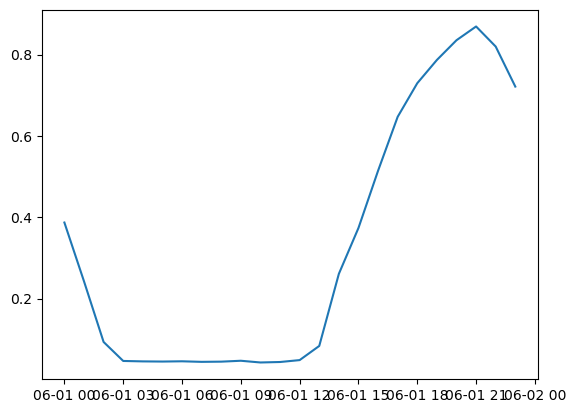

In [15]:
plt.plot(ds['time'].sel(time='2024-06-01'),eto_timeseries.sel(time='2024-06-01'))

<xarray.DataArray 'time' (time: 8784)> Size: 70kB
array(['2024-01-01T00:00:00.000000000', '2024-01-01T01:00:00.000000000',
       '2024-01-01T02:00:00.000000000', ..., '2024-12-31T21:00:00.000000000',
       '2024-12-31T22:00:00.000000000', '2024-12-31T23:00:00.000000000'],
      shape=(8784,), dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 70kB 2024-01-01 ... 2024-12-31T23:00:00
Attributes:
    long_name:       time
    time_increment:  one hour
    begin_date:      20231231
    begin_time:      230000
    end_date:        20240101
    end_time:        000000
    bounds:          time_bnds

In [ ]:
# Extract ETo time series at the nearest matching location
eto_timeseries = ds["ETo"].sel(elevation=nearest_elev, lat=nearest_lat, lon=nearest_lon)

# Extract PotEvap time series at the same location
pot_evap_timeseries = ds["PotEvap"].sel(lat=nearest_lat, lon=nearest_lon)

# Plot time series of ETo
plt.figure(figsize=(10, 5))
plt.plot(ds["time"], eto_timeseries, marker='o', linestyle='-', label="ETo")
plt.xlabel("Time")
plt.ylabel("ETo (mm/hour)")
plt.title(f"Time Series of ETo at Lat: {nearest_lat}, Lon: {nearest_lon}, Elev: {nearest_elev}m")
plt.legend()
plt.xticks(rotation=45)
plt.grid()
plt.show()


In [16]:
ini_dir = pathlib.Path('../../station_config/')



dataset = {}
for year in range(2022, 2025):
    ds = xarray.open_dataset(f"{year}_with_eto.nc",)
    dfs = {}
    for file in ini_dir.glob('US*.ini'):

        name = file.stem
        print(name)
        config = configparser.ConfigParser()
        config.read(file)

        # Define the target latitude, longitude, and elevation (adjust as needed)
        target_lat = pd.to_numeric(config['METADATA']["station_latitude"])
        target_lon = pd.to_numeric(config['METADATA']["station_longitude"])
        target_elev = int(pd.to_numeric(config['METADATA']["station_elevation"]))

        # Find the nearest latitude, longitude, and elevation in the dataset
        nearest_lat = ds["lat"].sel(lat=target_lat, method="nearest").values
        nearest_lon = ds["lon"].sel(lon=target_lon, method="nearest").values
        nearest_elev = ds["elevation"].sel(elevation=target_elev, method="nearest").values

        # Extract ETo time series at the nearest matching location
        eto_timeseries = ds["ETo"].sel(elevation=nearest_elev, lat=nearest_lat, lon=nearest_lon)
        etr_timeseries = ds["ETr"].sel(elevation=nearest_elev, lat=nearest_lat, lon=nearest_lon)

        # Extract PotEvap time series at the same location
        pet_ts = ds["PotEvap"].sel(lat=nearest_lat, lon=nearest_lon)
        lwd_ts = ds["LWdown"].sel(lat=nearest_lat, lon=nearest_lon)
        swd_ts = ds["SWdown"].sel(lat=nearest_lat, lon=nearest_lon)
        temp_ts = ds["Tair"].sel(lat=nearest_lat, lon=nearest_lon)
        rh_ts = ds["Qair"].sel(lat=nearest_lat, lon=nearest_lon)
        pres_ts = ds['PSurf'].sel(lat=nearest_lat, lon=nearest_lon)
        wind_u_ts = ds['Wind_E'].sel(lat=nearest_lat, lon=nearest_lon)
        wind_v_ts = ds['Wind_N'].sel(lat=nearest_lat, lon=nearest_lon)
        wind_ts = np.sqrt(wind_u_ts ** 2 + wind_v_ts ** 2)

        dfs[name] = pd.DataFrame({'datetime':ds["time"],
                                  'eto':eto_timeseries,
                                  'etr':etr_timeseries,
                                  'pet':pet_ts,
                                  'lwdown':lwd_ts,
                                  'swdown':swd_ts,
                                  'temperature':temp_ts,
                                  'rh':rh_ts,
                                  'pressure':pres_ts,
                                  'wind':wind_ts,
                                  }).round(4)
    dataset[year] = pd.concat(dfs)
alldata = pd.concat(dataset)
alldata['datetime'] = pd.to_datetime(alldata['datetime'])

# Save DataFrame to Parquet
alldata.to_parquet('nldas_all.parquet')

US-CdM
US-UTB
US-UTD
US-UTE
US-UTJ
US-UTM
US-UTN
US-UTP
US-UTV
US-UTW
US-CdM
US-UTB
US-UTD
US-UTE
US-UTJ
US-UTM
US-UTN
US-UTP
US-UTV
US-UTW
US-CdM
US-UTB
US-UTD
US-UTE
US-UTJ
US-UTM
US-UTN
US-UTP
US-UTV
US-UTW


In [17]:
eto_df = pd.read_parquet('nldas_all.parquet')

eto_df = eto_df.reset_index().rename(columns={'level_0':'year',
                                              'level_1':'stationid'})
eto_df['datetime'] = eto_df['datetime'] - pd.Timedelta(hours=7)
eto_df = eto_df.set_index(['stationid','datetime'])
eto_df.to_parquet('nldas_all.parquet')


In [45]:
def norm_minmax_dly_et(x):
    # Normalize using min-max scaling and then divide by the sum,
    # rounding to 4 decimal places.
    return np.round(((x - x.min()) / (x.max() - x.min())), 4)

def norm_dly_et(x):
    return np.round(x/x.sum(), 4)


# Assuming eto_df has a datetime index or a 'datetime' column:
df = eto_df.reset_index()
df['date'] = df['datetime'].dt.date
df['hour'] = df['datetime'].dt.hour

# Define the desired hour range (inclusive start, exclusive end)
start_hour = 6
end_hour = 18

# Filter the DataFrame for only the hours within the specified range
mask = (df['hour'] >= start_hour) & (df['hour'] <= end_hour)
df_subset = df.loc[mask].copy()

# Apply the normalization for each station and each day
df_subset['daily_min_max_ETo'] = df_subset.groupby(['stationid', 'date'])['eto'].transform(norm_minmax_dly_et)
df_subset['daily_ETo_normed'] = df_subset.groupby(['stationid', 'date'])['daily_min_max_ETo'].transform(norm_dly_et)
df_subset = df_subset.set_index(['stationid','datetime'])

df_final = pd.merge(eto_df,
                    df_subset[['daily_min_max_ETo','daily_ETo_normed']],
                    how='left',
                    left_index=True,
                    right_index=True,)
#df_final = df.merge(df_subset[['datetime', 'daily_ETo_normed']], on='datetime', how='left')
df_final['daily_ETo_normed'] = df_final['daily_ETo_normed'].fillna(0)
df_final.to_parquet('nldas_all_normed.parquet')

In [44]:
df_final

year_x  level_2_x   eto_x   etr_x   pet_x  \
stationid datetime                                                         
US-CdM    2021-12-31 17:00:00    2022          0  0.0178  0.0211  0.0825   
          2021-12-31 18:00:00    2022          1  0.0112  0.0139  0.0052   
          2021-12-31 19:00:00    2022          2  0.0053  0.0073  0.0052   
          2021-12-31 20:00:00    2022          3  0.0000  0.0012  0.0052   
          2021-12-31 21:00:00    2022          4  0.0002  0.0015  0.0081   
...                               ...        ...     ...     ...     ...   
US-UTW    2024-12-31 12:00:00    2024       8779  0.1566  0.1995  0.1473   
          2024-12-31 13:00:00    2024       8780  0.1551  0.1980  0.1473   
          2024-12-31 14:00:00    2024       8781  0.1392  0.1814  0.1473   
          2024-12-31 15:00:00    2024       8782  0.1011  0.1358  0.0755   
          2024-12-31 16:00:00    2024       8783  0.0530  0.0800  0.0755   

                                 lwdown_x    swdown_x  temperature_x    rh_x  \
stationid datetime                                                             
US-CdM    2021-12-31 17:00:00  269.670013    4.400000     276.920013  0.0043   
          2021-12-31 18:00:00  269.679993    0.000000     275.959991  0.0042   
          2021-12-31 19:00:00  269.679993    0.000000     275.000000  0.0042   
          2021-12-31 20:00:00  277.220001    0.000000     274.040009  0.0042   
          2021-12-31 21:00:00  277.220001    0.000000     273.859985  0.0040   
...                                   ...         ...            ...     ...   
US-UTW    2024-12-31 12:00:00  182.779999  450.346985     271.929993  0.0020   
          2024-12-31 13:00:00  182.759995  437.032990     272.489990  0.0021   
          2024-12-31 14:00:00  184.889999  385.660004     273.049988  0.0022   
          2024-12-31 15:00:00  184.929993  293.871002     272.089996  0.0022   
          2024-12-31 16:00:00  184.960007  165.806000     271.140015  0.0021   

                                 pressure_x  ...    lwdown_y    swdown_y  \
stationid datetime                           ...                           
US-CdM    2021-12-31 17:00:00  80793.734375  ...  269.670013    4.400000   
          2021-12-31 18:00:00  80769.898438  ...  269.679993    0.000000   
          2021-12-31 19:00:00  80746.695312  ...         NaN         NaN   
          2021-12-31 20:00:00  80722.859375  ...         NaN         NaN   
          2021-12-31 21:00:00  80764.656250  ...         NaN         NaN   
...                                     ...  ...         ...         ...   
US-UTW    2024-12-31 12:00:00  83837.398438  ...  182.779999  450.346985   
          2024-12-31 13:00:00  83838.296875  ...  182.759995  437.032990   
          2024-12-31 14:00:00  83839.296875  ...  184.889999  385.660004   
          2024-12-31 15:00:00  83842.296875  ...  184.929993  293.871002   
          2024-12-31 16:00:00  83845.398438  ...  184.960007  165.806000   

                               temperature_y    rh_y    pressure_y  wind_y  \
stationid datetime                                                           
US-CdM    2021-12-31 17:00:00     276.920013  0.0043  80793.734375  6.0104   
          2021-12-31 18:00:00     275.959991  0.0042  80769.898438  4.9612   
          2021-12-31 19:00:00            NaN     NaN           NaN     NaN   
          2021-12-31 20:00:00            NaN     NaN           NaN     NaN   
          2021-12-31 21:00:00            NaN     NaN           NaN     NaN   
...                                      ...     ...           ...     ...   
US-UTW    2024-12-31 12:00:00     271.929993  0.0020  83837.398438  3.1438   
          2024-12-31 13:00:00     272.489990  0.0021  83838.296875  3.0410   
          2024-12-31 14:00:00     273.049988  0.0022  83839.296875  2.9373   
          2024-12-31 15:00:00     272.089996  0.0022  83842.296875  2.6350   
          2024-12-31 16:00:00     271.140015  0.0021  83845.398438  2.3277  